In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

2.5.0


In [39]:
column_names = ['id','date','price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated', 'zipcode','lat','long','sqft_living15','sqft_lot15']

raw_dataset = pd.read_csv('./data/kc_house_data.csv', names=column_names,
                          na_values='?',
                          header = 1,
                          sep=',', skipinitialspace=False)
raw_dataset = raw_dataset.drop(columns = ['id', 'date']) # 'lat', 'long', 'zipcode'
dataset = raw_dataset.copy()
dataset = dataset.dropna()

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

selected_features = selected_features = ['sqft_living', 'sqft_lot', 'bedrooms','bathrooms', 'view', 'condition', 'grade']
# selected_features = ['sqft_living']
#np_selected_features = np.array(train_features[selected_features])
#normalizer = preprocessing.Normalization(input_shape=[7,])
#normalizer.adapt(np_selected_features)

In [40]:
def loss_one(W, X, res):
    prediction = np.dot(W[:-1], X) + W[-1]
    return abs(res - prediction)

def loss_all(W, train_features, train_labels):
    """
    :param W: weights
    :param train_features: features
    :param train_labels: labels
    :return: MAE (MEAN ABSOLUTE ERROR) loss
    """
    total_loss = 0
    for i in range(train_features.shape[0]):
        total_loss += loss_one(W, train_features[i], train_labels[i])

    return total_loss / train_features.shape[0]

def loss_all_implicit(W):
    """
    Wrapper that implicitely sets the train_features and train_label params.
    Used to be passed to the PSO class bellow
    """
    return loss_all(W, train_features, train_labels)

In [41]:
train_features = train_features[selected_features].to_numpy()
train_labels = train_labels.to_numpy()
test_features = test_features[selected_features].to_numpy()
test_labels = test_labels.to_numpy()

In [42]:
dims = train_features.shape[1] + 1
dims


8

In [44]:
test_run_weight = np.ones(dims)
print(f"loss one: {loss_one(test_run_weight, train_features[0], train_labels[0])}")
print(f"loss training: {loss_all(test_run_weight, train_features, train_labels)}")
print(f"loss test: {loss_all(test_run_weight, test_features, test_labels)}")

loss one: 672224.5
loss training: 524700.2175390399
loss test: 517692.8043729755


In [45]:
class PSO(object):
    def __init__(self, func, init_pos, n_particles):
        self.func = func
        self.n_particles = n_particles
        self.init_pos = np.array(init_pos)
        self.particle_dim = len(init_pos)
        self.particles_pos = np.random.uniform(size=(n_particles, self.particle_dim)) \
                             * self.init_pos
        self.velocities = np.random.uniform(size=(n_particles, self.particle_dim))

        # Initialize the best positions
        self.g_best = init_pos
        self.p_best = self.particles_pos

    def update_position(self, x, v):
        """
        x (array-like): particle current position.
        v (array-like): particle current velocity.
        """
        x = np.array(x)
        v = np.array(v)
        new_x = x + v
        return new_x

    def update_velocity(self, x, v, p_best, g_best, c0=0.5, c1=1.5, w=0.75):
        """
        x (array-like): particle current position.
        v (array-like): particle current velocity.
        p_best (array-like): the best position found so far for a particle.
        g_best (array-like): the best position regarding
                             all the particles found so far.
        c0 (float): the cognitive scaling constant.
        c1 (float): the social scaling constant.
        w (float): the inertia weight
        """
        x = np.array(x)
        v = np.array(v)
        assert x.shape == v.shape, 'Position and velocity must have same shape'
        # a random number between 0 and 1.
        r = np.random.uniform()
        p_best_np = np.array(p_best)
        g_best_np = np.array(g_best)

        new_v = w * v + c0 * r * (p_best_np - x) + c1 * r * (g_best_np - x)
        return new_v

    def optimize(self, maxiter=25):
        losses = []
        for it in range(maxiter):
            for i in range(self.n_particles):
                x = self.particles_pos[i]
                v = self.velocities[i]
                p_best = self.p_best[i]
                self.velocities[i] = self.update_velocity(x, v, p_best, self.g_best)
                self.particles_pos[i] = self.update_position(x, v)
                # Update the best position for particle i
                if self.func(self.particles_pos[i]) < self.func(p_best):
                    self.p_best[i] = self.particles_pos[i]
                # Update the best position overall

                old_val = self.func(self.g_best)
                new_val = self.func(self.particles_pos[i])
                if new_val < old_val:
                    self.g_best = np.copy(self.particles_pos[i])
                    print(f"Better loss, from {old_val} to {new_val} with particle {self.g_best}")
            losses.append(self.func(self.g_best))
            print(f"Iteration {it}, loss: {losses[-1]}, particle: {self.g_best}")

        return self.g_best, self.func(self.g_best), losses

In [46]:
pso_instance = PSO(func=loss_all_implicit, init_pos=test_run_weight, n_particles=25)
res_s, last_loss, hist_loss = pso_instance.optimize()
res_s


Better loss, from 524700.2175390399 to 515669.7919649196 with particle [1.457 1.616 1.318 1.289 1.225 1.029 1.359 1.408]
Better loss, from 515669.7919649196 to 509237.3617480759 with particle [1.538 2.159 1.438 1.505 1.514 1.074 1.809 1.352]
Better loss, from 509237.3617480759 to 504440.8675858936 with particle [1.848 2.573 1.516 1.946 1.507 1.718 1.827 1.473]
Better loss, from 504440.8675858936 to 502982.382963073 with particle [1.637 2.777 1.592 1.999 1.552 2.005 1.957 1.879]
Better loss, from 502982.382963073 to 493426.40117611084 with particle [2.529 3.716 2.554 3.036 2.451 3.106 2.8   2.847]
Better loss, from 493426.40117611084 to 481612.5311713106 with particle [3.439 5.249 4.085 4.581 3.529 4.403 3.892 4.475]
Better loss, from 481612.5311713106 to 480932.050387617 with particle [3.74  5.263 4.393 4.384 3.752 4.575 4.264 4.611]
Better loss, from 480932.050387617 to 464715.58463008306 with particle [5.405 7.973 6.192 6.436 5.558 6.55  6.2   6.797]
Better loss, from 464715.58463008

array([246.638,  -0.373, 174.586,  87.786, 128.499, 100.612, 157.898,
       299.47 ])

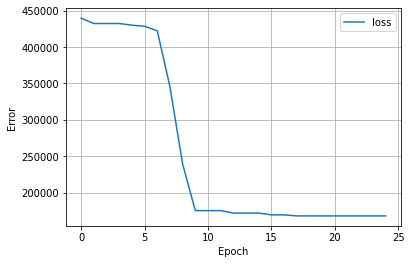

In [47]:
def plot_loss(history):
  plt.plot(history, label='loss')
  plt.xlabel('Epoch')

  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(hist_loss)

In [48]:
print(f"Final test loss: {loss_all(res_s, test_features, test_labels)}")

Final test loss: 166536.95971584925
